In [ ]:
# !pip install yfinance

In [ ]:
# !pip install keras-tuner

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import hashlib
import json
from datetime import datetime, timedelta

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import keras_tuner as kt

In [3]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100.0

print("TensorFlow:", tf.__version__)
print("Using CUDA GPU:", tf.config.list_physical_devices('GPU'))

TensorFlow: 2.20.0
Using CUDA GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# end_date = datetime.now()
end_date = "2025-11-24"
start_date = "2003-09-18"
horizon = "1d"

print("Start date:", start_date)
print("End date:", end_date)

Start date: 2003-09-18
End date: 2025-11-24


In [5]:
gold = yf.download("GC=F", start = start_date, end = end_date, interval = horizon, auto_adjust = False)
silver = yf.download("SI=F", start = start_date, end = end_date, interval = horizon,auto_adjust = False)
cad = yf.download("CADUSD=X", start = start_date, end = end_date, interval = horizon, auto_adjust = False)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
gold.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5572 entries, 2003-09-18 to 2025-11-21
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, GC=F)  5572 non-null   float64
 1   (Close, GC=F)      5572 non-null   float64
 2   (High, GC=F)       5572 non-null   float64
 3   (Low, GC=F)        5572 non-null   float64
 4   (Open, GC=F)       5572 non-null   float64
 5   (Volume, GC=F)     5572 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 304.7 KB


In [7]:
silver.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5573 entries, 2003-09-18 to 2025-11-21
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, SI=F)  5573 non-null   float64
 1   (Close, SI=F)      5573 non-null   float64
 2   (High, SI=F)       5573 non-null   float64
 3   (Low, SI=F)        5573 non-null   float64
 4   (Open, SI=F)       5573 non-null   float64
 5   (Volume, SI=F)     5573 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 304.8 KB


In [8]:
cad.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5770 entries, 2003-09-18 to 2025-11-21
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   (Adj Close, CADUSD=X)  5770 non-null   float64
 1   (Close, CADUSD=X)      5770 non-null   float64
 2   (High, CADUSD=X)       5770 non-null   float64
 3   (Low, CADUSD=X)        5770 non-null   float64
 4   (Open, CADUSD=X)       5770 non-null   float64
 5   (Volume, CADUSD=X)     5770 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 315.5 KB


In [9]:
def asset_heatmap(df, asset_name):
    plt.figure(figsize=(7, 5))
    sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
    plt.title(f"{asset_name} Feature Correlation Heatmap")
    plt.show()

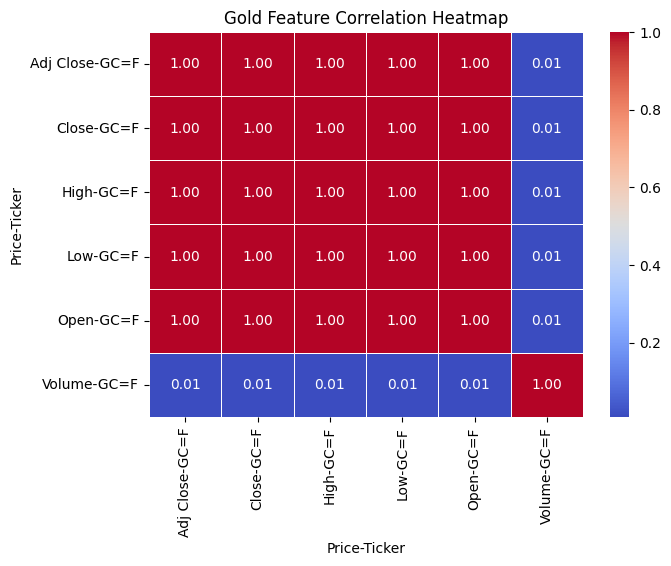

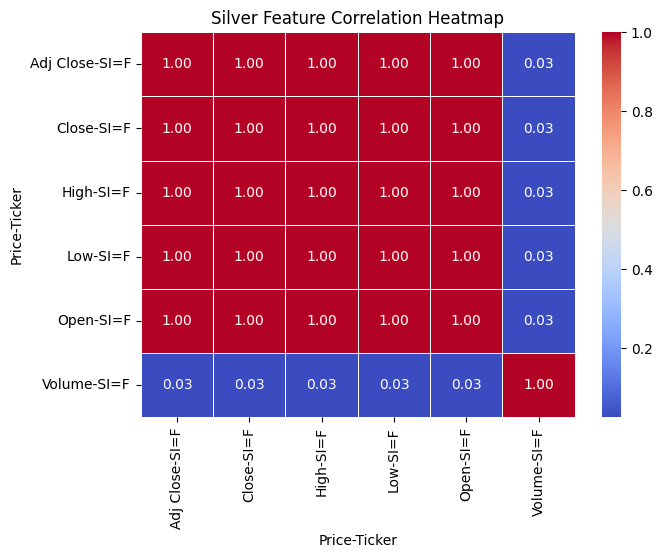

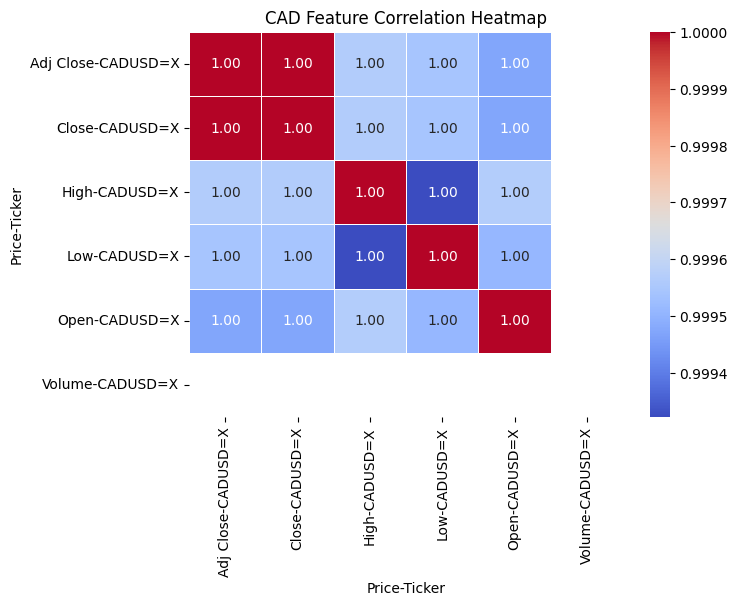

In [10]:
asset_heatmap(gold, "Gold")
asset_heatmap(silver, "Silver")
asset_heatmap(cad, "CAD")

In [11]:
gold = gold[["Close"]].rename(columns={"Close": "Gold"})
silver = silver[["Close"]].rename(columns={"Close": "Silver"})
cad = cad[["Close"]].rename(columns={"Close": "CAD"})

In [12]:
all_prices = gold.join([silver, cad], how="outer")
all_prices.to_csv("prices_with_null.csv")

In [13]:
all_prices = all_prices.ffill().bfill() # forward-fill + backward-fill to deal with missing values
all_prices.to_csv("prices.csv")

In [14]:
all_prices.head()

Price,Gold,Silver,CAD
Ticker,GC=F,SI=F,CADUSD=X
Date,,,
2003-09-18,376.600006,5.255,0.734484
2003-09-19,381.799988,5.282,0.742280
2003-09-22,387.200012,5.265,0.738443
2003-09-23,385.899994,5.235,0.737953
2003-09-24,387.500000,5.302,0.740686


In [15]:
all_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5785 entries, 2003-09-18 to 2025-11-21
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Gold, GC=F)     5785 non-null   float64
 1   (Silver, SI=F)   5785 non-null   float64
 2   (CAD, CADUSD=X)  5785 non-null   float64
dtypes: float64(3)
memory usage: 180.8 KB


In [16]:
all_prices.describe()

Price,Gold,Silver,CAD
Ticker,GC=F,SI=F,CADUSD=X
count,5785.000000,5785.000000,5785.000000
mean,1364.121088,19.550137,0.837579
std,652.181083,8.362776,0.100352
min,369.200012,4.810000,0.679486
25%,935.599976,14.400000,0.753852
50%,1288.400024,17.683001,0.798537
75%,1729.199951,24.238001,0.935716
max,4336.399902,53.332001,1.088495


## feature engineering

In [ ]:
# # adding features that make more sense than raw data
# all_prices["Gold_ret"] = all_prices["Gold"].pct_change()
# all_prices["Silver_ret"] = all_prices["Silver"].pct_change()
# all_prices["CAD_ret"] = all_prices["CAD"].pct_change()

# all_prices["Gold_ma"] = all_prices["Gold"].rolling(5).mean()
# all_prices["Silver_ma"] = all_prices["Silver"].rolling(5).mean()
# all_prices["CAD_ma"] = all_prices["CAD"].rolling(5).mean()

# all_prices = all_prices.dropna()

In [ ]:
# all_prices.head()

In [ ]:
# all_prices.to_csv("prices_engineered.csv")

In [ ]:
# scaler = MinMaxScaler()
# scaled = scaler.fit_transform(all_prices)

# scaled_prices = pd.DataFrame(scaled, index=all_prices.index, columns=all_prices.columns)

In [17]:
import tensorflow as tf

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def mae(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def mape(y_true, y_pred):
    return tf.reduce_mean(tf.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

In [18]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(all_prices)

def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i : i + timesteps])
        y.append(data[i + timesteps])
    return np.array(X), np.array(y)

In [32]:
max_window = 60

X_all, y_all = create_sequences(scaled, max_window)

split = int(len(X_all) * 0.8)
X_train, X_test = X_all[:split], X_all[split:]
y_train, y_test = y_all[:split], y_all[split:]

In [33]:
# hyperparameter tuning

def build_model(hp):
    model = Sequential()
    
    window = hp.Int("window", min_value=10, max_value=100, step=10)
    
    rnn_type = hp.Choice("rnn_type", ["LSTM", "GRU"])
    rnn_layer = LSTM if rnn_type == "LSTM" else GRU

    # first layer
    model.add(
        rnn_layer(
            units=hp.Int("units_1", min_value=16, max_value=128, step=16),
            return_sequences=True,
            input_shape=(window, 3),
            kernel_regularizer=l2(hp.Choice("l2_reg", [1e-6, 1e-5, 1e-4])),
        )
    )
    model.add(Dropout(hp.Float("dropout_1", 0.1, 0.5, step=0.1)))

    # second layer
    model.add(
        rnn_layer(
            units=hp.Int("units_2", min_value=8, max_value=64, step=8),
            return_sequences=False,
            kernel_regularizer=l2(hp.Choice("l2_reg2", [1e-6, 1e-5, 1e-4])),
        )
    )
    model.add(Dropout(hp.Float("dropout_2", 0.1, 0.5, step=0.1)))

    # dense layer
    model.add(Dense(hp.Int("dense_units", 8, 64, step=8), activation="relu"))

    # output
    model.add(Dense(3))

    # learning rate
    lr = hp.Choice("learning_rate", [1e-2, 5e-3, 1e-3, 5e-4, 1e-4])

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss="mse",
        metrics=[rmse, mae, mape]
    )

    return model

In [34]:
tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective("val_rmse", direction="min"),
    max_trials=30,
    executions_per_trial=1,
    directory="tuning_results",
    project_name="gold_silver_cad",
)

In [35]:
def tuner_search(tuner, scaled_data):
    for trial in range(tuner.max_trials):
        hp = tuner.oracle.populate_space(trial).hyperparameters
        window = hp.get("window")

        X, y = create_sequences(scaled_data, window)

        split = int(len(X) * 0.8)
        X_train, y_train = X[:split], y[:split]

        batch_size = hp.Choice("batch_size", [16, 32, 64])

        tuner.oracle.update_trial(
            trial_id=trial,
            metrics={"val_rmse": float("inf")}
        )

        tuner.search(
            X_train, y_train,
            epochs=50,
            batch_size=batch_size,
            validation_split=0.2,
            callbacks=[tf.keras.callbacks.EarlyStopping(
                monitor="val_loss", patience=5, restore_best_weights=True
            )],
            verbose=1
        )

In [39]:
earlystop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

tuner.search(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[earlystop],
    verbose=1
)

Trial 30 Complete [00h 00m 25s]
val_rmse: 0.022464275360107422

Best val_rmse So Far: 0.019654158502817154
Total elapsed time: 00h 13m 43s


In [40]:
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best Hyperparameters:")
best_hp.values

best_model = tuner.get_best_models(1)[0]

print(best_hp.values)
best_model.summary()

{'window': 70, 'rnn_type': 'GRU', 'units_1': 48, 'l2_reg': 0.0001, 'dropout_1': 0.4, 'units_2': 16, 'l2_reg2': 0.0001, 'dropout_2': 0.1, 'dense_units': 8, 'learning_rate': 0.0005}


/home/rita/anaconda3/envs/Python3.11/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 70, 48)         │         7,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 70, 48)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 16)             │         3,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,963 (42.82 KB)

 Trainable params: 10,963 (42.82 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

y_pred = best_model.predict(X_test)

y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

rmse_val = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae_val  = mean_absolute_error(y_test_inv, y_pred_inv)
mape_val = mean_absolute_percentage_error(y_test_inv, y_pred_inv)

print("RMSE:", rmse_val)
print("MAE :", mae_val)
print("MAPE:", mape_val)

model = best_model

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
RMSE: 276.83326836206186
MAE : 129.62326799320513
MAPE: 0.07372683253594343


In [44]:
y_pred = model.predict(X_test)

# inverse scale
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [45]:
baseline = scaler.inverse_transform(X_test[:, -1, :]) # last real point

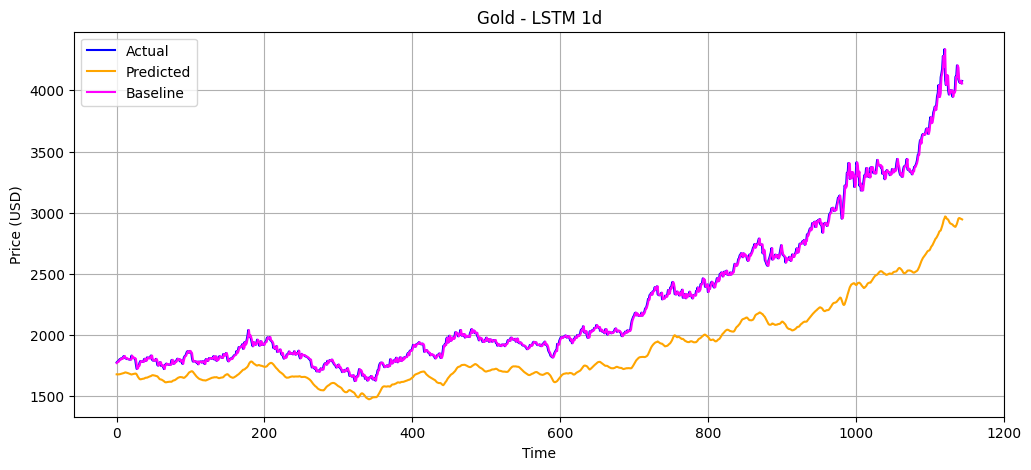

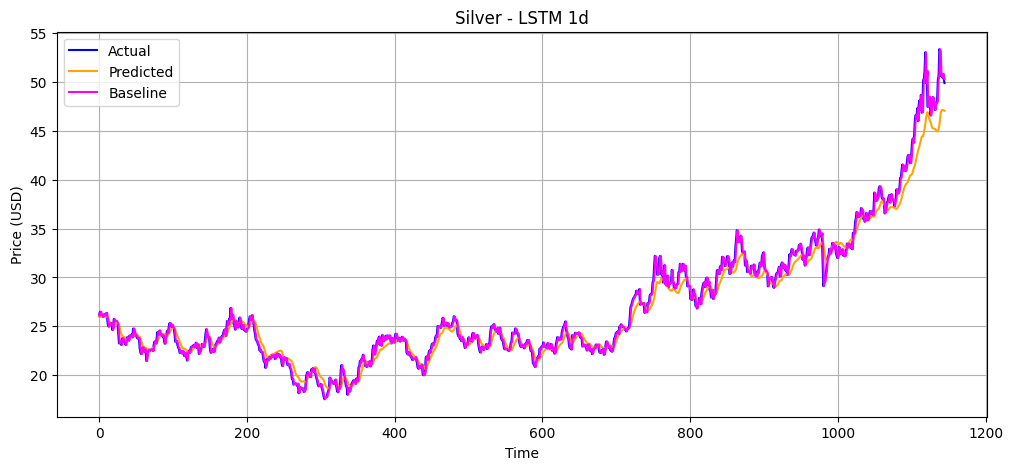

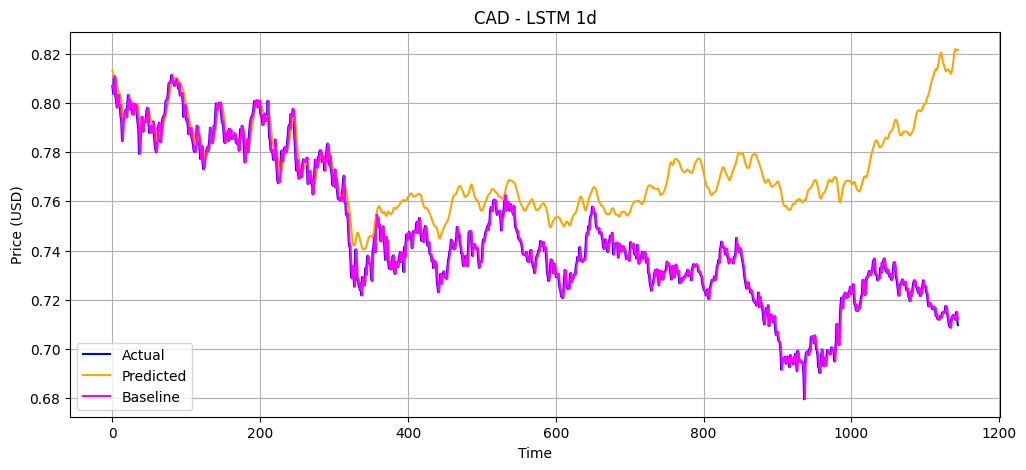

In [46]:
def plot_asset(i, asset_name):
    plt.figure(figsize=(12,5))
    plt.plot(y_test_inv[:, i], label="Actual", color="blue")
    plt.plot(y_pred_inv[:, i], label="Predicted", color="orange")
    plt.plot(baseline[:, i], label="Baseline", color="magenta")
    plt.title(f"{asset_name} - LSTM 1d")
    plt.xlabel("Time")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_asset(0, "Gold")
plot_asset(1, "Silver")
plot_asset(2, "CAD")

In [47]:
def mae(y, p): return np.mean(np.abs(y-p))
def rmse(y, p): return np.sqrt(np.mean((y-p)**2))
def mape(y, p): return np.mean(np.abs((y-p)/y))*100

assets = ["Gold","Silver","CAD"]
for i in range(3):
    print(assets[i])
    print(" MAE :", mae(y_test_inv[:,i], y_pred_inv[:,i]))
    print(" RMSE:", rmse(y_test_inv[:,i], y_pred_inv[:,i]))
    print(" MAPE:", mape(y_test_inv[:,i], y_pred_inv[:,i]))
    print()

Gold
 MAE : 387.9999529842726
 RMSE: 479.4877408963422
 MAPE: 15.326954742646079

Silver
 MAE : 0.8419302678004101
 RMSE: 1.2166816086700551
 MAPE: 2.935591361818835

CAD
 MAE : 0.02792072754239411
 RMSE: 0.03784242877301256
 MAPE: 3.8555036563180907



Enter date range exactly in this format inside the parenthesis, with the start date first (DD-MM-YYYY; DD-MM-YYYY): 20-11-2025; 28-11-2025


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


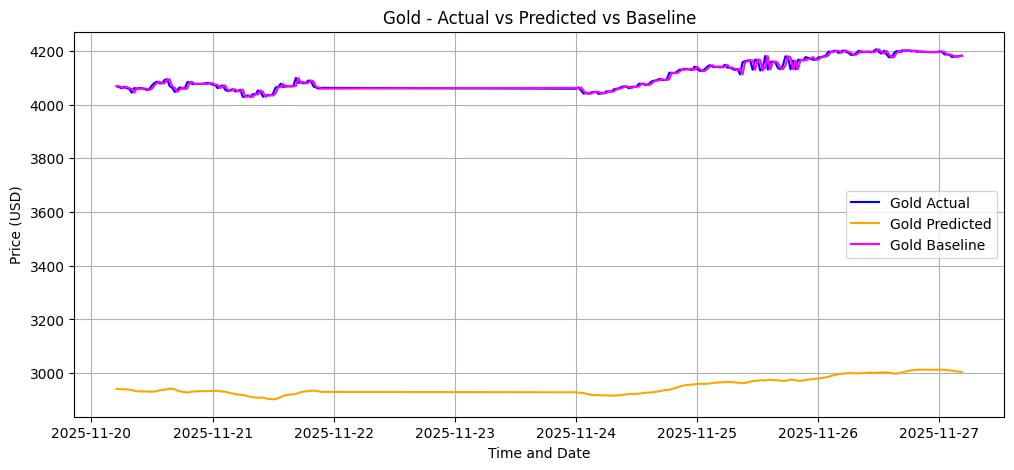

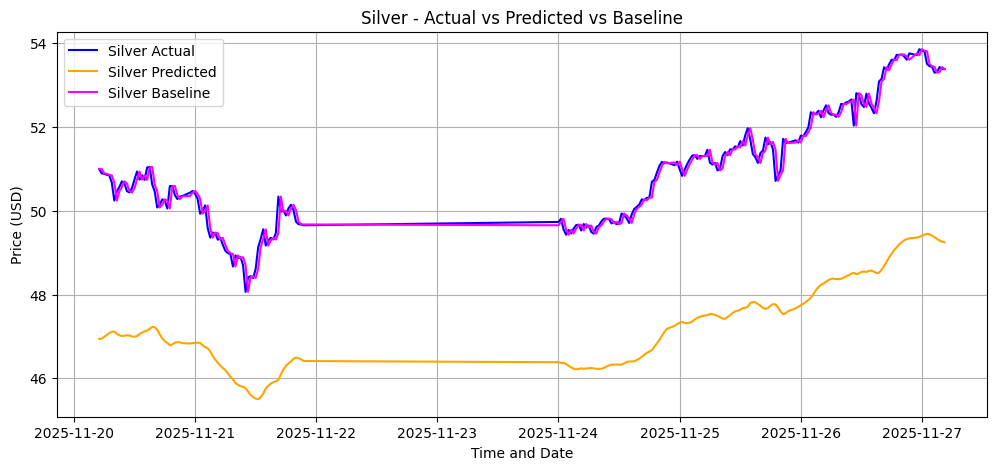

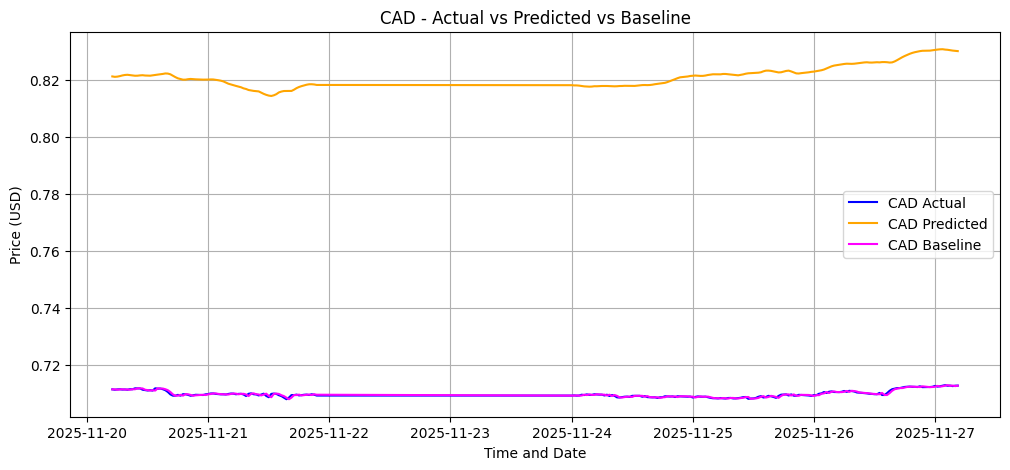

In [48]:
predict_window = 60

def parse_range(user_input): #format: DD-MM-YYYY; DD-MM-YYYY
   # example: 10-12-2025; 14-12-2025
    if ";" not in user_input:
        raise ValueError("Invalid format. Use: DD-MM-YYYY; DD-MM-YYYY")

    parts = user_input.split(";")
    if len(parts) != 2:
        raise ValueError("Invalid format. Use: DD-MM-YYYY; DD-MM-YYYY")

    start_str = parts[0].strip()
    end_str   = parts[1].strip()

    try:
        start = datetime.strptime(start_str, "%d-%m-%Y")
        end   = datetime.strptime(end_str, "%d-%m-%Y")
    except:
        raise ValueError("Invalid date. Use exactly this format: DD-MM-YYYY; DD-MM-YYYY")

    return start, end

def user_date():
    while True:
        user_input = input("Enter date range exactly in this format inside the parenthesis, with the start date first (DD-MM-YYYY; DD-MM-YYYY): ")

        try:
            start, end = parse_range(user_input)
            return user_input
        except Exception as e:
            print(f"\nError: {str(e)}\nPlease try again.\n")


def predict_range(date_string, interval="30m"):
    start, end = parse_range(date_string)

    # downloading data to be able to compare with the actual value
    gold = yf.download("GC=F", start=start, end=end, interval=interval, auto_adjust = False)[["Close"]].rename(columns={"Close": "Gold"})
    silver = yf.download("SI=F", start=start, end=end, interval=interval, auto_adjust = False)[["Close"]].rename(columns={"Close": "Silver"})
    cad = yf.download("CADUSD=X", start=start, end=end, interval=interval, auto_adjust = False)[["Close"]].rename(columns={"Close": "CAD"})
    
    
    data = gold.join([silver, cad], how="outer").dropna()

    if data.shape[0] == 0:
        raise ValueError(
            f"No Yahoo Finance data found between {start.date()} and {end.date()} "
            f"for interval='{interval}'. "
            "Try an earlier date range that already has price history."
        )

    scaled_data = scaler.transform(data)

    X_seq = []
    last_seq = scaled[-predict_window:]
    window = np.vstack([scaled[-predict_window:], scaled_data])

    for i in range(len(data)):
        seq = window[i:i+predict_window]
        if seq.shape[0] == predict_window:
            X_seq.append(seq)

    X_seq = np.array(X_seq)

    preds = model.predict(X_seq)
    preds_inv = scaler.inverse_transform(preds)

    data["Gold_pred"], data["Silver_pred"], data["CAD_pred"] = (
        preds_inv[:, 0], preds_inv[:, 1], preds_inv[:, 2]
    )

    return data


def plot_results(df):
    assets = ["Gold", "Silver", "CAD"]
    for asset in assets:
        actual = df[asset].values
        predicted = df[f"{asset}_pred"].values
        
        # baseline: next price = current actual
        baseline = np.roll(actual, 1)
        baseline[0] = actual[0]  

        plt.figure(figsize=(12,5))
        plt.plot(df.index, actual, label=f"{asset} Actual", color="blue")
        plt.plot(df.index, predicted, label=f"{asset} Predicted", color="orange")
        plt.plot(df.index, baseline, label=f"{asset} Baseline", color="magenta")
        
        plt.title(f"{asset} - Actual vs Predicted vs Baseline")
        plt.xlabel("Time and Date")
        plt.ylabel("Price (USD)")
        plt.legend()
        plt.grid(True)
        plt.show()


# 20-11-2025; 28-11-2025
user_range = user_date()
user_df = predict_range(user_range, interval="30m")
plot_results(user_df)

In [49]:
user_df.head()

Price,Gold,Silver,CAD,Gold_pred,Silver_pred,CAD_pred
Ticker,GC=F,SI=F,CADUSD=X,,,
Datetime,,,,,,
2025-11-20 05:00:00+00:00,4068.899902,51.000000,0.711389,2940.926025,46.940151,0.821100
2025-11-20 05:30:00+00:00,4065.100098,50.895000,0.711263,2940.209961,46.948181,0.820954
2025-11-20 06:00:00+00:00,4061.600098,50.884998,0.711364,2939.884521,46.989197,0.821030
2025-11-20 06:30:00+00:00,4066.899902,50.860001,0.711420,2939.510498,47.036388,0.821207
2025-11-20 07:00:00+00:00,4061.399902,50.845001,0.711318,2939.078613,47.079357,0.821448


Enter date range exactly in this format inside the parenthesis, with the start date first (DD-MM-YYYY; DD-MM-YYYY): 28-11-2025; 01-12-2025


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


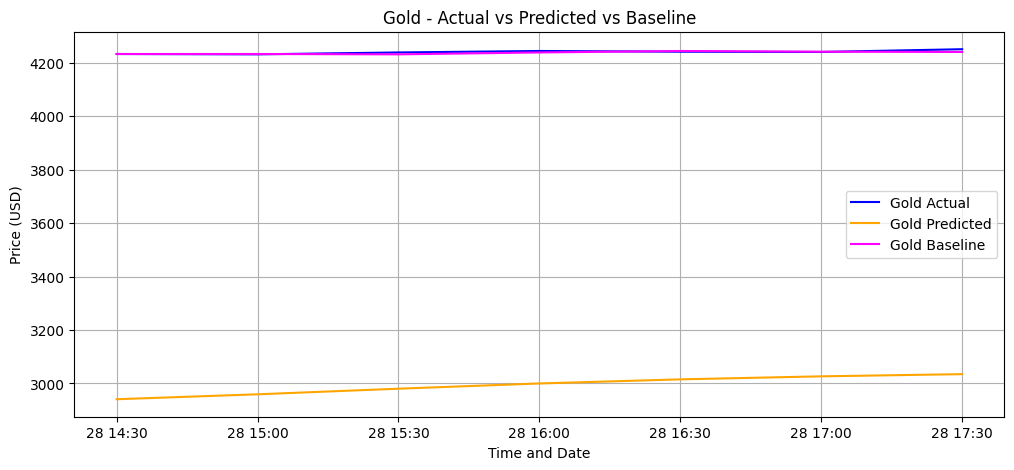

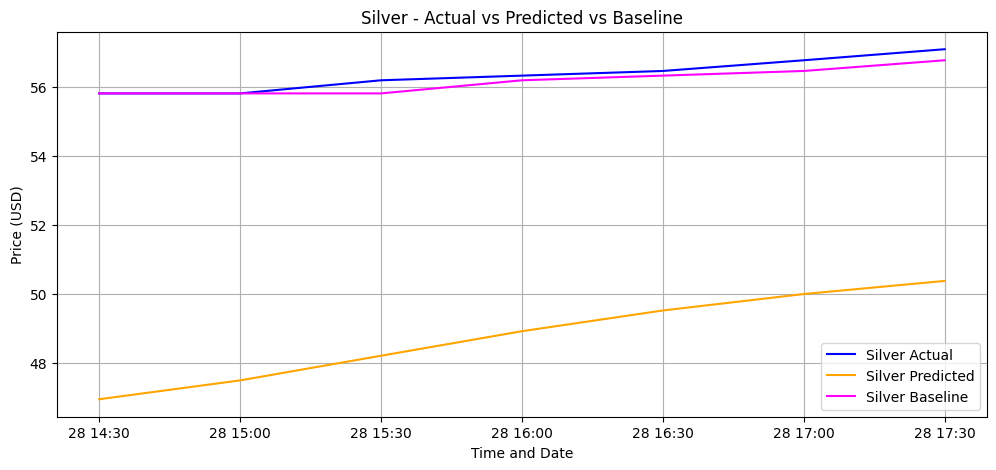

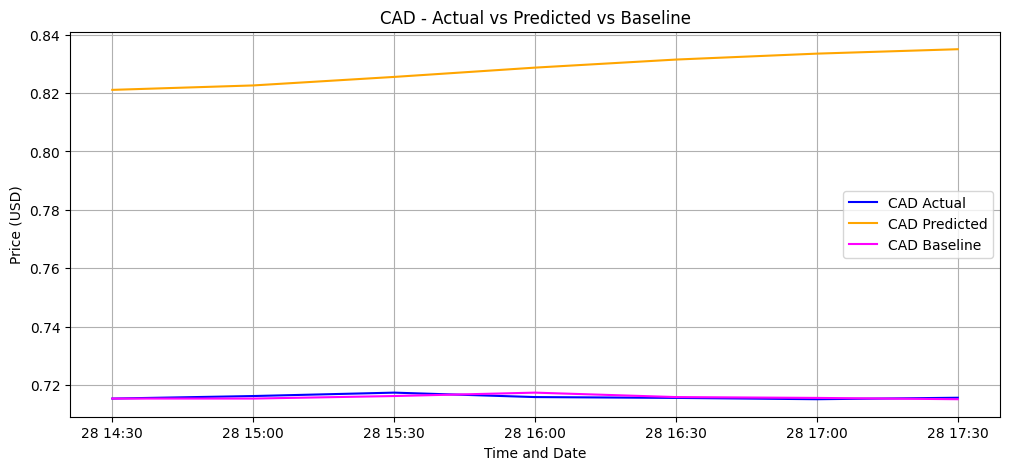

In [50]:
# 28-11-2025; 01-12-2025
user_range = user_date()
user_df = predict_range(user_range, interval="30m")
user_df.head()
plot_results(user_df)

In [51]:
user_df.head()

Price,Gold,Silver,CAD,Gold_pred,Silver_pred,CAD_pred
Ticker,GC=F,SI=F,CADUSD=X,,,
Datetime,,,,,,
2025-11-28 14:30:00+00:00,4233.500000,55.799999,0.715308,2940.985840,46.940582,0.821101
2025-11-28 15:00:00+00:00,4232.200195,55.799999,0.716173,2959.420166,47.485790,0.822620
2025-11-28 15:30:00+00:00,4239.299805,56.180000,0.717340,2980.426514,48.200024,0.825540
2025-11-28 16:00:00+00:00,4244.799805,56.314999,0.715820,2999.982178,48.910831,0.828725
2025-11-28 16:30:00+00:00,4242.100098,56.450001,0.715533,3015.346924,49.511307,0.831488
